<a href="https://colab.research.google.com/github/shadowscythe03/es335-24-fall-assignment-2/blob/master/task_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torchvision
import os
import torchvision.transforms as transforms
import matplotlib.gridspec as gridspec
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import warnings
from sklearn import preprocessing
warnings.filterwarnings('ignore')
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

torch.Size([3, 485, 341])


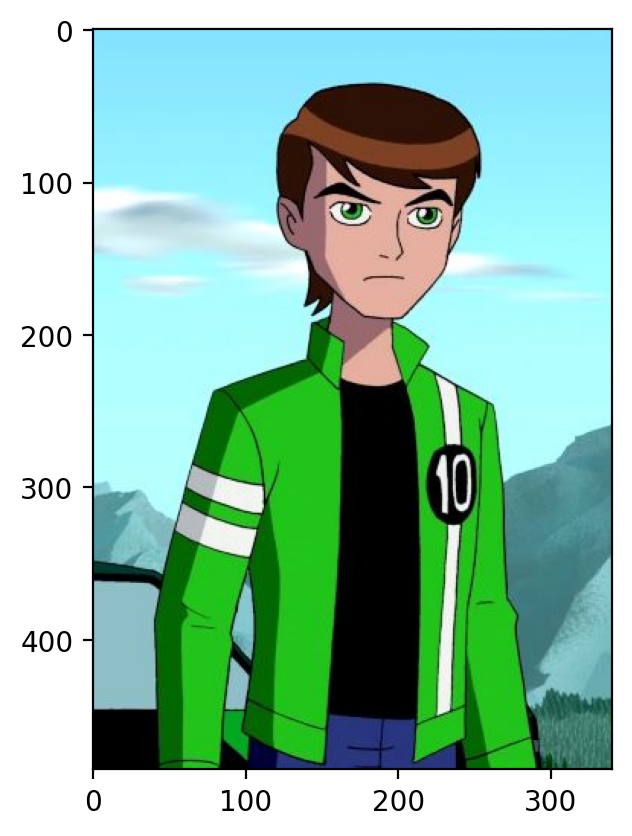

In [4]:
# if os.path.exists('dog.jpg'):
#     print('dog.jpg exists')
# else:
#     url = 'https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg'
#     response = requests.get(url)
#     if response.status_code == 200:
#         with open('dog.jpg', 'wb') as file:
#             file.write(response.content)
#         print('dog.jpg downloaded successfully')
#     else:
#         print('Failed to download dog.jpg')

img = torchvision.io.read_image('ben_10_copy.jpg')
img = img.clone()
print(img.shape)
img = img.permute(1,2,0)
plt.imshow(img)
# plt.imshow(img, cmap='gray')

**task-4 part-1**

tensor(149142)


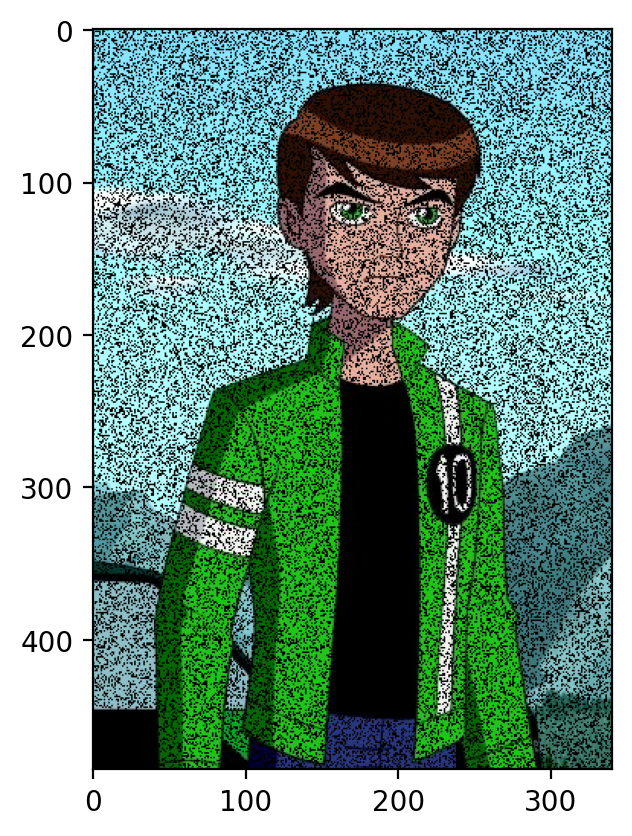

In [6]:
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
def mask_2d_image(img, prop):
    img_copy = img.clone()
    mask = torch.rand(img.shape) < prop
    img_copy[mask] = float('nan')
    return img_copy, mask

def mask_image(img, prop):
    #img (torch.Tensor): A 3D image tensor of shape (height, width, channels).
    img_copy = img.clone()
    img_copy = img_copy.to(torch.float32)

    # Generate a 2D mask of shape (height, width)
    mask_2d = torch.rand(img.shape[0], img.shape[1]) < prop

    # Expand mask to match the image's 3D shape (height, width, channels)
    mask = mask_2d.unsqueeze(2).expand_as(img)

    # Set masked values to NaN
    img_copy[mask] = float('nan')
    # img_copy = img_copy.permute(1,2,0)
    
    return img_copy, mask

masked_image, mask = mask_image(img, 0.3)
print(mask.sum())
plt.imshow(masked_image.to(torch.uint8))

In [15]:
def factorize(A, k, device=torch.device("cpu"), epsilon = 0.001):
    """Factorize the matrix D into A and B"""
    A = A.to(device)
    # Randomly initialize A and B
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
    # Optimizer
    optimizer = optim.Adam([W, H], lr=0.01)
    mask = ~torch.isnan(A)
    epoch = 0
    # Train the model
    while True:
        # Compute the loss
        diff_matrix = torch.mm(W, H) - A
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)

        # Zero the gradients
        optimizer.zero_grad()

        # Backpropagate
        loss.backward()

        # Update the parameters
        optimizer.step()
        epoch += 1
        if epoch>1:
            if prev_loss-loss < epsilon:
                break
        # if epoch>=100 and epoch%100==0:
        #     print(f'Epoch:{epoch}--->Loss:{loss}, prev_loss:{prev_loss}')
        prev_loss = loss

    # print(f'No of Epochs:{epoch}')

    return W, H, loss

def reconstruct_2d_img(masked_image,factors=50,device=torch.device("cpu")):#returns torch
    W, H, _ = factorize(masked_image,factors,device)
    reconstruct_img = torch.mm(W, H).cpu().detach()
    return reconstruct_img

def factorize_3d(A, k, device=torch.device("cpu"), epsilon = 0.001):
	A = A.to(device)
	if A.shape[2] == 3:
		# A1,A2,A3 = A[:,:,0],A[:,:,1],A[:,:,2]
		A_3d = A.permute(2,0,1)
	else:
		A_3d = A
	W_3d = []
	H_3d = []
	loss_3d = []

	for a in A_3d:
		W,H,loss = factorize(a,k,device,epsilon)
		W_3d.append(W)
		H_3d.append(H)
		loss_3d.append(loss)

	return W_3d,H_3d,loss_3d

def reconstruct_3d_img(masked_image,factors=50,device=torch.device("cpu")):
	W_3d,H_3d,_ = factorize_3d(masked_image,factors,device)
	A = []
	for i in range(3):
		a = torch.mm(W_3d[i], H_3d[i]).cpu().detach()
		A.append(a)
	A = torch.stack(A)
	A = A.permute(1,2,0)
	A = torch.clamp(A,min=0,max=1)
	return A.cpu().detach()



In [32]:
def compute_rmse(tensor1, tensor2):
    # Ensure both tensors are on the same device (GPU)
    assert tensor1.shape == tensor2.shape, "Tensors must have the same shape"

    mse = torch.mean((tensor1 - tensor2) ** 2)
    rmse = torch.sqrt(mse)
    return rmse.item()

def compute_psnr(tensor1, tensor2, max_pixel_value=1.0):
    mse = torch.mean((tensor1 - tensor2) ** 2)
    psnr = 10 * torch.log10(max_pixel_value ** 2 / mse)
    return psnr.item()


def plot_image_completion(img, prop=0.3, factors=50):
    masked_image, mask = mask_image(img, prop)
    reconstructed_img = reconstruct_3d_img(masked_image, factors)
    print(f'For Reconstructed and Original Images with prop:{prop}, factors:{factors}')
    print(f'RMSE:{compute_rmse(reconstructed_img,img)} and PSNR:{compute_psnr(reconstructed_img,img)}')
    print(f'For Reconstructed and Masked Images with prop:{prop}, factors:{factors}')
    print(f'RMSE:{compute_rmse(reconstructed_img[~mask],masked_image[~mask])} and PSNR:{compute_psnr(reconstructed_img[~mask],masked_image[~mask])}')
    reconstructed_img = reconstructed_img.numpy()
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(masked_image.to(torch.uint8))
    ax[0].set_title("Masked image")
    ax[1].imshow(img)
    ax[1].set_title("Original image")
    ax[2].imshow(reconstructed_img)
    ax[2].set_title("Reconstructed image")
    fig.suptitle(f'prop:{prop}, factors:{factors}')
    plt.show()

For Reconstructed and Original Images with prop:0.3, factors:50
RMSE:168.1036376953125 and PSNR:-44.51154327392578
For Reconstructed and Masked Images with prop:0.3, factors:50
RMSE:168.04627990722656 and PSNR:-44.508575439453125


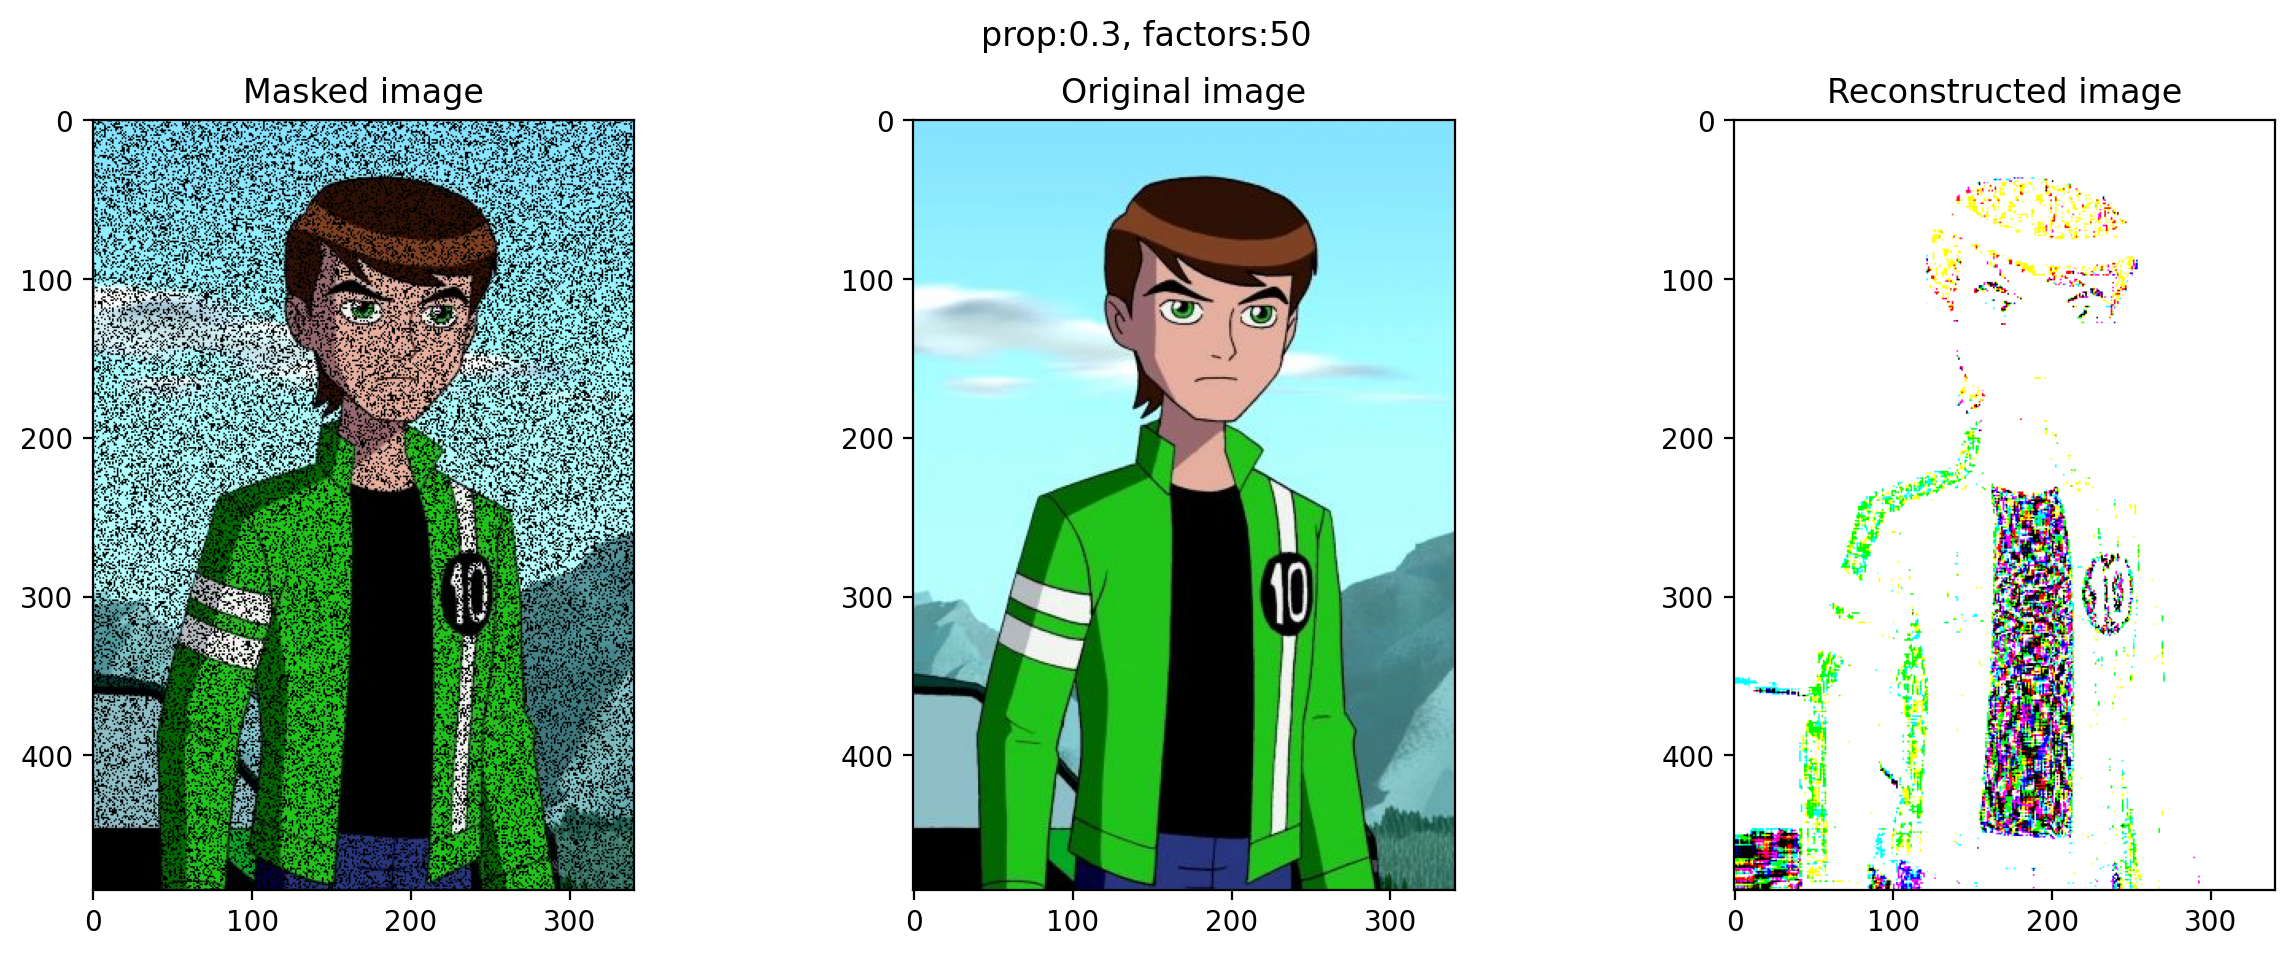

In [33]:
plot_image_completion(img)
# prop_i = [0.1,0.3,0.5,0.7,0.9]
# factors_i = [5,10,25,50]
# for i in prop_i:
#     for j in factors_i:
#         plot_image_completion(prop=i,factors=j)



**task-4 part-2**

torch.Size([3, 485, 341])


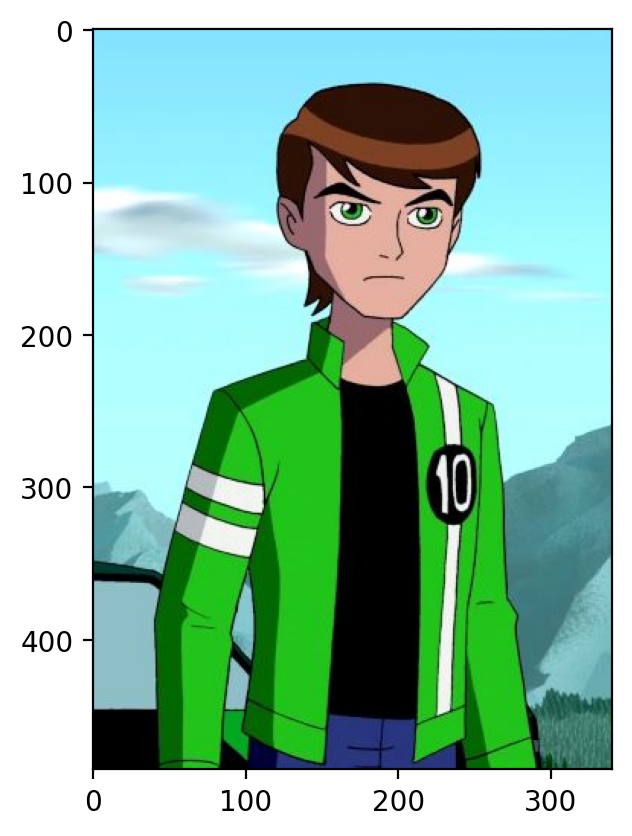

In [27]:
# crop2 = torchvision.transforms.functional.crop(img, 800, 100, 300, 300)
# plt.imshow(crop2, cmap="gray")
img = torchvision.io.read_image('ben_10_copy.jpg')
img = img.clone()
print(img.shape)
img = img.permute(1,2,0)
plt.imshow(img)


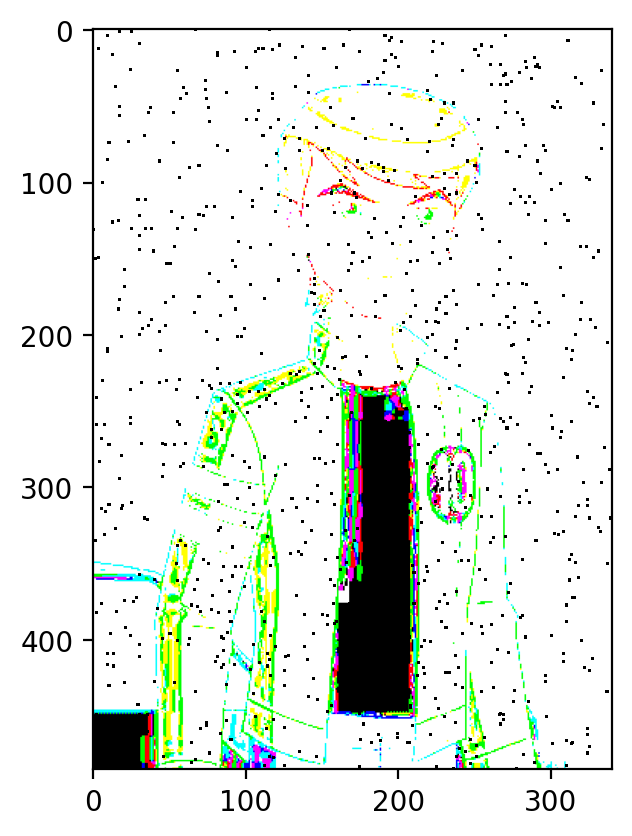

In [30]:
import numpy as np
import torch
import matplotlib.pyplot as plt

import torch

def mask_900_3d(img, num_masked_pixels = 900):
    # # Ensure the image tensor is in floating-point format
    img_copy = img.clone()
    img_copy = img_copy.to(torch.float32)
    img_shape = img_copy.shape

    # total_pixels = img_shape[0] * img_shape[1] * img_shape[2]
    
    # # Randomly select indices to mask
    # mask_indices = torch.randperm(total_pixels)[:num_masked_pixels]
    
    # # Create a boolean mask
    # mask = torch.zeros(total_pixels, dtype=torch.bool)
    # mask[mask_indices] = True
    
    # # Reshape mask to match the image shape
    # mask = mask.view(img_shape)
    
    # # Create a copy of the image to avoid modifying the original tensor
    # img_copy = img.clone()
    
    # # Apply the mask: replace masked values with NaN
    # img_copy[mask] = float('nan')
    total_pixels = img_shape[0] * img_shape[1]
    mask_indices = torch.randperm(total_pixels)[:num_masked_pixels]
    mask = torch.zeros(total_pixels, dtype=torch.bool)
    mask[mask_indices] = True
    mask = mask.view(img_shape[:2])
    mask = mask.unsqueeze(2).expand_as(img)
    img_copy[mask] = float('nan')
    
    return img_copy, mask

def mask_900_pixel(img):
    img = img.clone()  # Clone to avoid modifying the original image

    # Set random seeds and generate random starting points
    np.random.seed(50)
    a = np.random.randint(0, 269)
    np.random.seed(78)
    b = np.random.randint(0, 269)

    # Create a 30x30 mask filled with NaN
    mask = np.zeros((30, 30))
    mask[mask == 0] = float('nan')
    mask = torch.from_numpy(mask).float()

    # Apply the mask to the image in the specified region (2D image case)
    img[a:a+30, b:b+30] = mask

    # Save the masked rows and columns
    masked_rows = range(a, a+30)
    masked_cols = range(b, b+30)

    # Return the modified image and the masked rows and columns
    return img, masked_rows, masked_cols

# Assuming 'crop' is the input 2D grayscale image tensor
# mask_900_img, masked_rows, masked_cols = mask_900_pixel(crop)
mask_900_img, mask = mask_900_3d(img)

# Convert tensor to numpy for visualization
mask_900_img_np = mask_900_img.numpy()  # Directly convert since no channels
mask_900_img_np = np.clip(mask_900_img_np, 0,1)
# Plot the masked image
plt.imshow(mask_900_img_np)
plt.show()

# # Print the masked row and column ranges
# print(f"Masked rows: {list(masked_rows)}")
# print(f"Masked cols: {list(masked_cols)}")


In [35]:
# def plot_image_reconstructed(masked_image,crop, factors=50):
#     mask = masked_image.isnan()
#     reconstructed_img = reconstruct_img(masked_image, factors)
#     print(f'For Reconstructed and Original Images with factors:{factors}')
#     print(f'RMSE:{compute_rmse(reconstructed_img,crop)} and PSNR:{compute_psnr(reconstructed_img,crop)}')
#     print(f'For Reconstructed and Masked Images with factors:{factors}')
#     print(f'RMSE:{compute_rmse(reconstructed_img[~mask],masked_image[~mask])} and PSNR:{compute_psnr(reconstructed_img[~mask],masked_image[~mask])}')
#     reconstructed_img = reconstructed_img.numpy()
#     fig, ax = plt.subplots(1, 3, figsize=(15, 5))
#     ax[0].imshow(masked_image, cmap='gray')
#     ax[0].set_title("Masked image")
#     ax[1].imshow(crop, cmap="gray")
#     ax[1].set_title("Original image")
#     ax[2].imshow(reconstructed_img, cmap='gray')
#     ax[2].set_title("Reconstructed image")
#     # fig.suptitle(f'factors:{factors}')
#     plt.show()

def plot_image_reconstructed(img,prop=0.3, factors=50):
    masked_image, mask = mask_900_3d(img)
    reconstructed_img = reconstruct_3d_img(masked_image, factors)
    print(f'For Reconstructed and Original Images with prop:{prop}, factors:{factors}')
    print(f'RMSE:{compute_rmse(reconstructed_img,img)} and PSNR:{compute_psnr(reconstructed_img,img)}')
    print(f'For Reconstructed and Masked Images with prop:{prop}, factors:{factors}')
    print(f'RMSE:{compute_rmse(reconstructed_img[~mask],masked_image[~mask])} and PSNR:{compute_psnr(reconstructed_img[~mask],masked_image[~mask])}')
    reconstructed_img = reconstructed_img.numpy()
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(masked_image.to(torch.uint8))
    ax[0].set_title("Masked image")
    ax[1].imshow(img)
    ax[1].set_title("Original image")
    ax[2].imshow(reconstructed_img)
    ax[2].set_title("Reconstructed image")
    fig.suptitle(f'prop:{prop}, factors:{factors}')
    plt.show()

For Reconstructed and Original Images with prop:0.3, factors:50
RMSE:168.1033935546875 and PSNR:-44.51152801513672
For Reconstructed and Masked Images with prop:0.3, factors:50
RMSE:168.09487915039062 and PSNR:-44.51108932495117


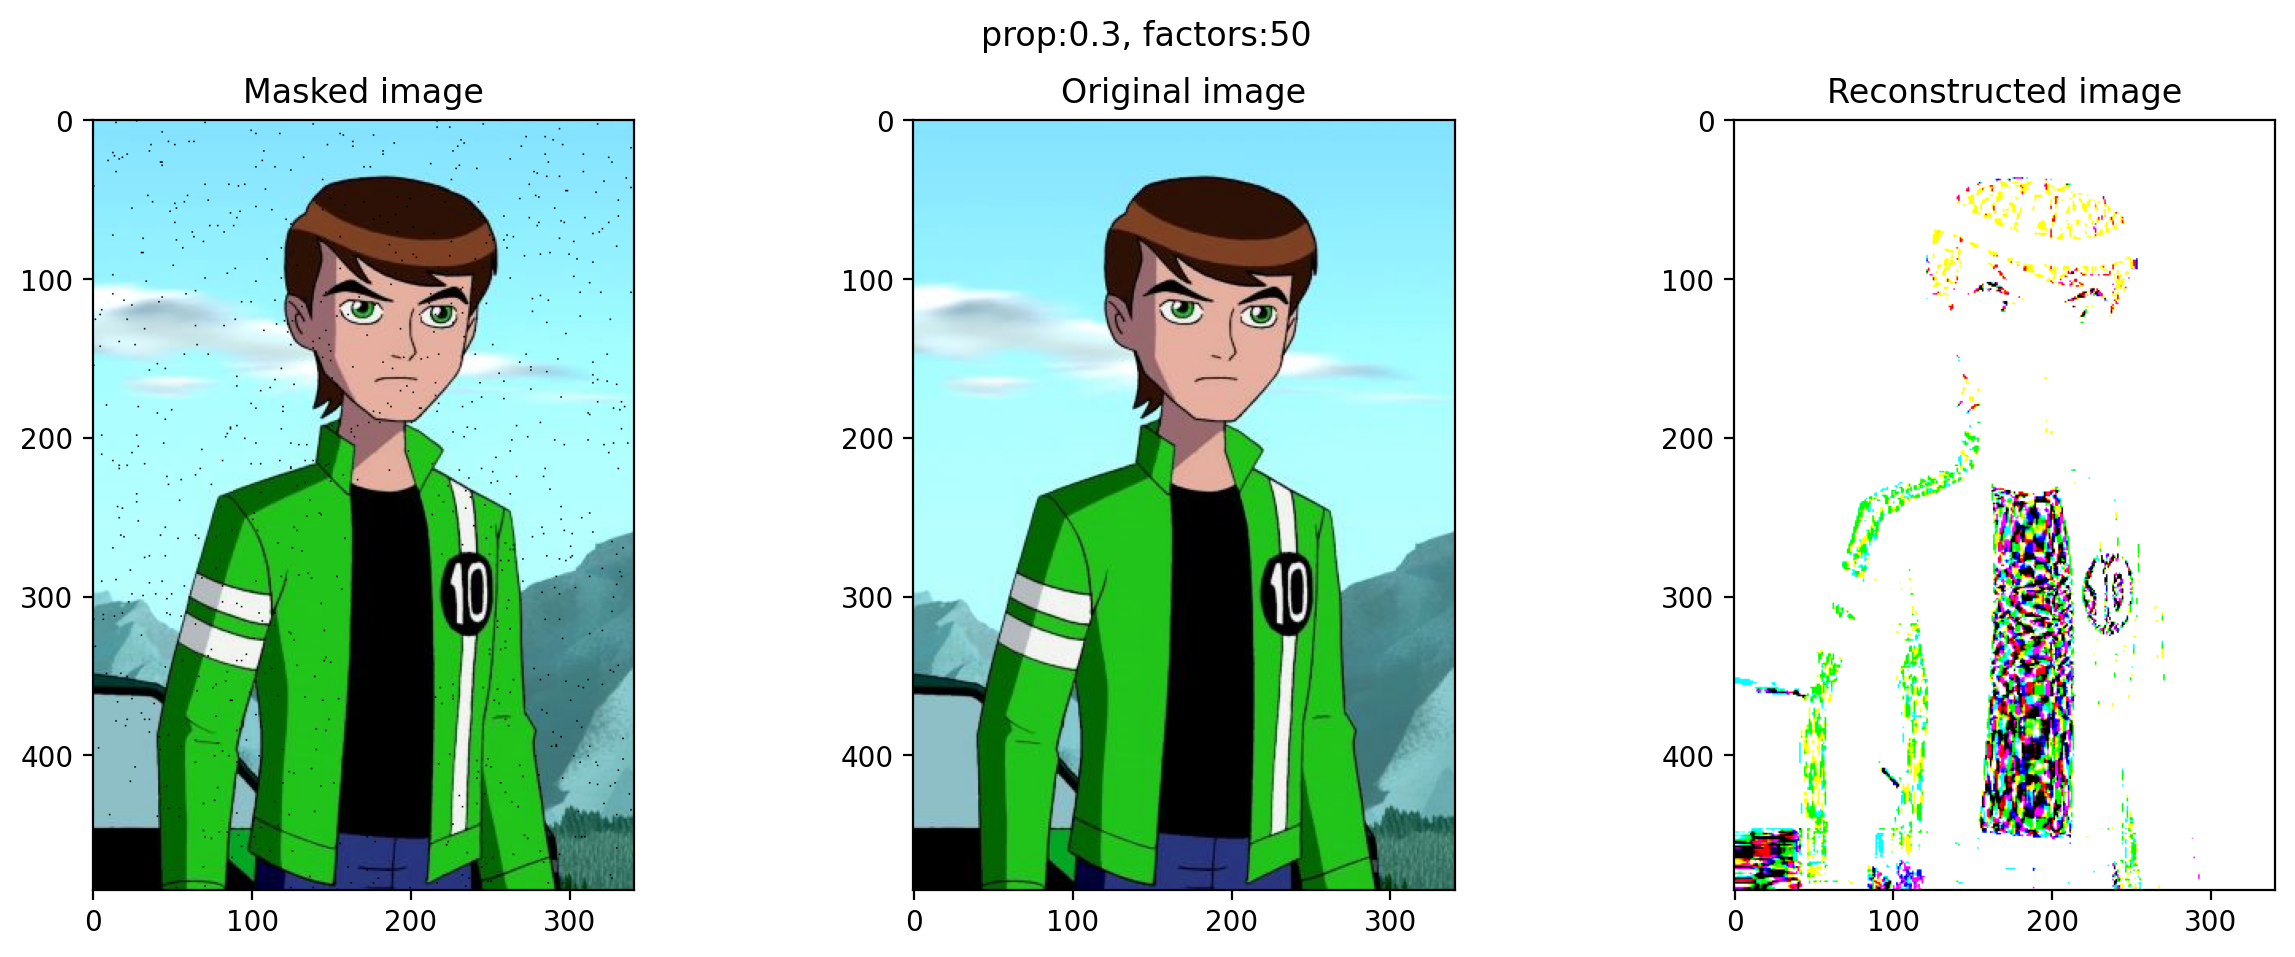

In [36]:
# mf_reconstructed_900_img = reconstruct_img(mask_900_img)
# plt.imshow(mf_reconstructed_900_img, cmap='gray')
plot_image_reconstructed(img, factors=50)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Reconstructed image')

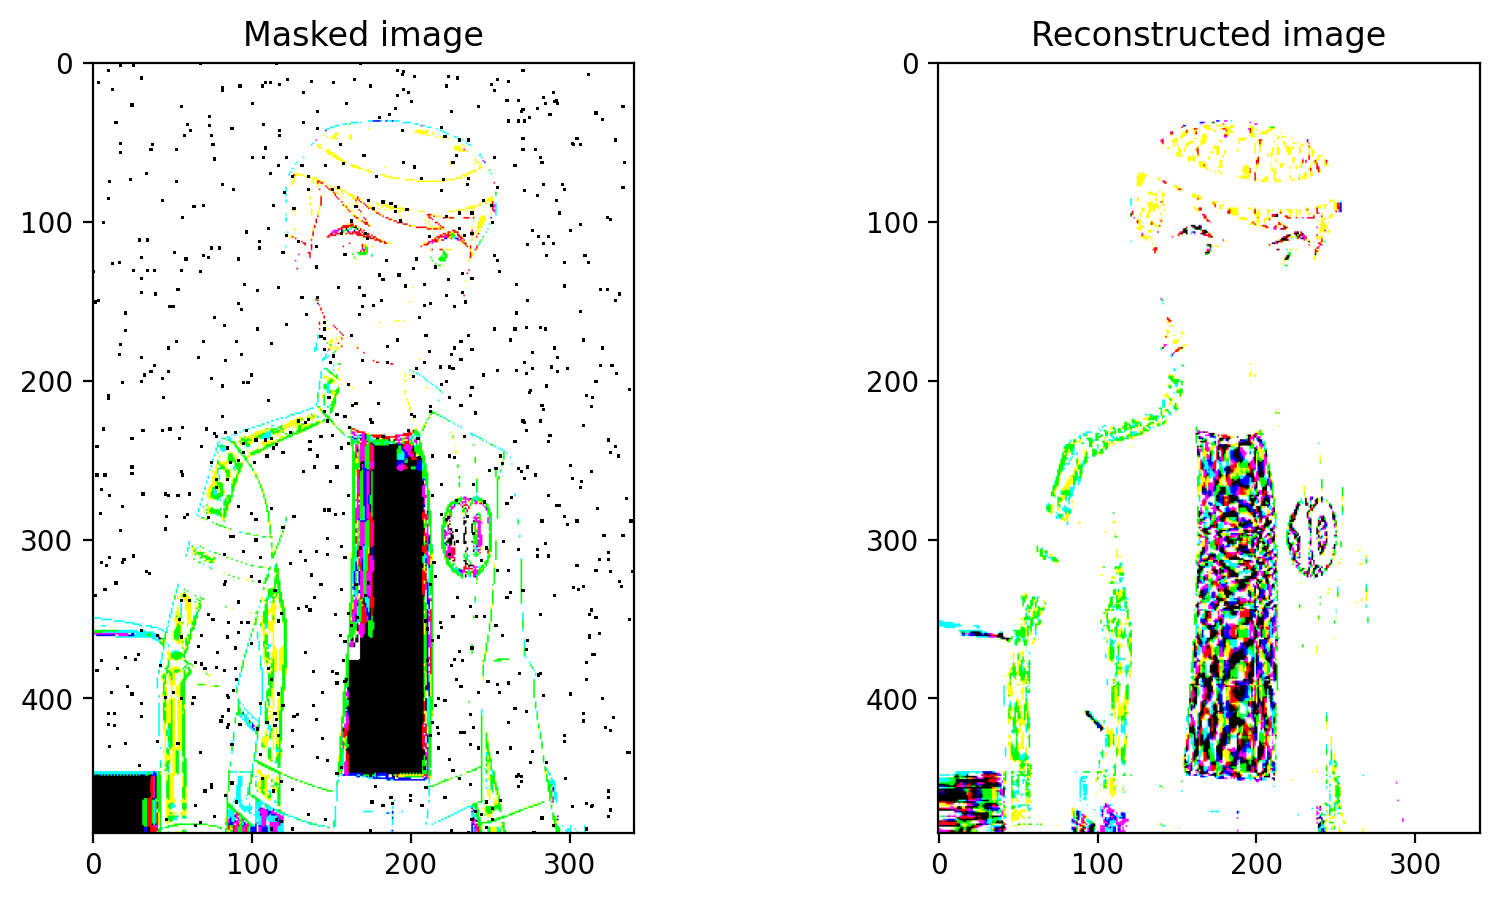

In [37]:
mf_reconstructed_900_img = reconstruct_3d_img(mask_900_img)
ig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(mask_900_img)
ax[0].set_title("Masked image")
ax[1].imshow(mf_reconstructed_900_img, cmap="gray")
ax[1].set_title("Reconstructed image")

In [16]:
print(mask_900_img.shape)

torch.Size([300, 300])


In [17]:
cropped_image = crop2
#mask_900_img, masked_rows, masked_cols = mask_900_pixel(cropped_image)

In [18]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    X = torch.stack([h_coords, w_coords], dim=1).to(torch.float32)

    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').to(torch.float32)
    return X, Y

# If the image is grayscale (2D), convert it to 3D (RGB-like format)
if cropped_image.dim() == 2:
    cropped_image = cropped_image.unsqueeze(0).repeat(3, 1, 1)

# if mask_900_img.dim() == 2:
#     mask_900_img = mask_900_img.unsqueeze(0).repeat(3, 1, 1)

# Coordinate mapping for the full image (RGB-like)
road_X, road_Y = create_coordinate_map(cropped_image)

# Convert masked rows and columns into a tensor representing the masked region
masked_img = cropped_image[:, masked_rows, :][:, :, masked_cols]

# Generate the coordinate map for the masked region
road_X_400, road_Y_400 = create_coordinate_map(masked_img)

# Move to GPU device
road_Y = road_Y.to(device)
road_Y_400 = road_Y_400.to(device)

# Scaling the coordinates using MinMaxScaler
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(road_X.cpu())  # road_X is scaled on the CPU
scaler_X_400 = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(road_X_400.cpu())

# Transforming the scaled coordinates
road_X_scaled = torch.tensor(scaler_X.transform(road_X.cpu())).to(device)
road_X_400_scaled = torch.tensor(scaler_X_400.transform(road_X_400.cpu())).to(device)

# Set to dtype float32
road_X_scaled = road_X_scaled.to(torch.float32)
road_X_400_scaled = road_X_400_scaled.to(torch.float32)



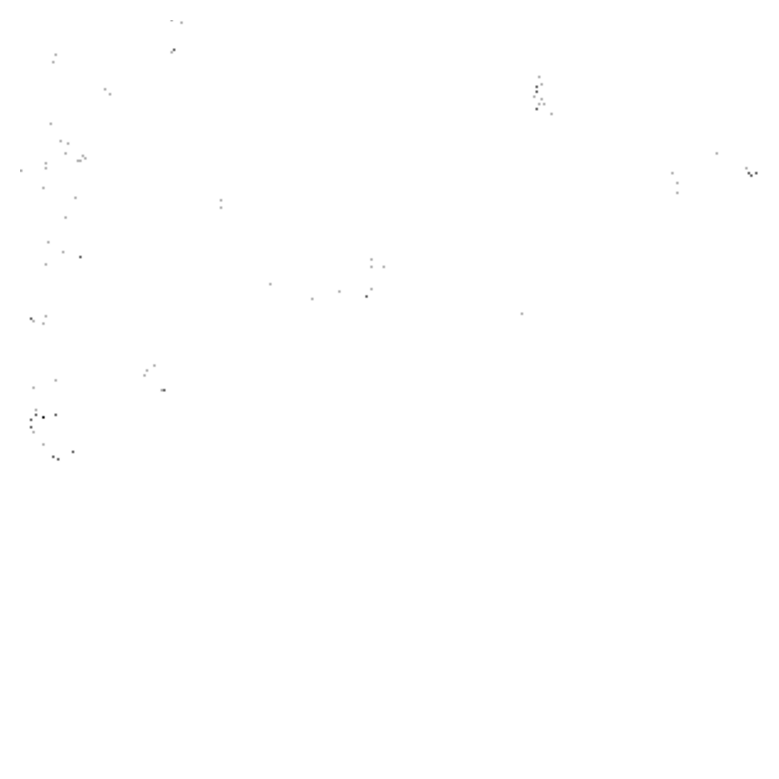

In [19]:
# Rearrange cropped_image to (height, width, channels) for displaying with plt.imshow
image_for_display = rearrange(cropped_image, 'c h w -> h w c')

# Display the image
plt.imshow(image_for_display.cpu().numpy())  # Convert to NumPy for plotting
plt.axis('off')  # Optional: Turn off axis if not needed
plt.show()

In [20]:
road_X_scaled[59909:59919]

tensor([[0.3311, 0.3980],
        [0.3311, 0.4047],
        [0.3311, 0.4114],
        [0.3311, 0.4181],
        [0.3311, 0.4247],
        [0.3311, 0.4314],
        [0.3311, 0.4381],
        [0.3311, 0.4448],
        [0.3311, 0.4515],
        [0.3311, 0.4582]], device='cuda:0')

In [21]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)
net = LinearModel(2, 3)
net.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [22]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")

    ##Now plotting for original image

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

def create_rff_features(X, num_features, sigma, device, batch_size=5000):
    n_samples, n_features = X.shape

    # Generate random weights and bias for RFF (weights can be large, so precompute and store on GPU)
    W = torch.randn(n_features, num_features, device=device) / sigma  # Random Gaussian weights
    b = 2 * torch.pi * torch.rand(num_features, device=device)  # Random bias

    Z_list = []  # Store the chunks of transformed data

    # Process the input in smaller batches to reduce memory usage
    for i in range(0, n_samples, batch_size):
        X_batch = X[i:i + batch_size]  # Slice the batch from the input tensor
        Z_batch = torch.matmul(X_batch, W) + b  # Linear transformation
        Z_batch = torch.cos(Z_batch) * (2.0 / torch.sqrt(torch.tensor(num_features, dtype=torch.float32, device=device)))  # Apply cosine and normalize
        Z_list.append(Z_batch)

    # Concatenate all the processed batches to form the final tensor
    Z = torch.cat(Z_list, dim=0)

    return Z

X_rff = create_rff_features(road_X_scaled, 10000, 0.008, device)
net = LinearModel(X_rff.shape[1], 3)    #same as 2, 3 only
net.to(device)

train(net, 0.005, X_rff, road_Y, 2500)

Epoch 0 loss: 10524.962891
Epoch 100 loss: 10413.917969
Epoch 200 loss: 10305.236328
Epoch 300 loss: 10198.631836
Epoch 400 loss: 10093.886719
Epoch 500 loss: 9990.831055
Epoch 600 loss: 9889.326172
Epoch 700 loss: 9789.263672
Epoch 800 loss: 9690.545898
Epoch 900 loss: 9593.097656
Epoch 1000 loss: 9496.845703
Epoch 1100 loss: 9401.734375
Epoch 1200 loss: 9307.709961
Epoch 1300 loss: 9214.724609
Epoch 1400 loss: 9122.741211
Epoch 1500 loss: 9031.719727
Epoch 1600 loss: 8941.628906
Epoch 1700 loss: 8852.439453
Epoch 1800 loss: 8764.122070
Epoch 1900 loss: 8676.653320
Epoch 2000 loss: 8590.012695
Epoch 2100 loss: 8504.175781
Epoch 2200 loss: 8419.127930
Epoch 2300 loss: 8334.847656
Epoch 2400 loss: 8251.322266


8169.35791015625

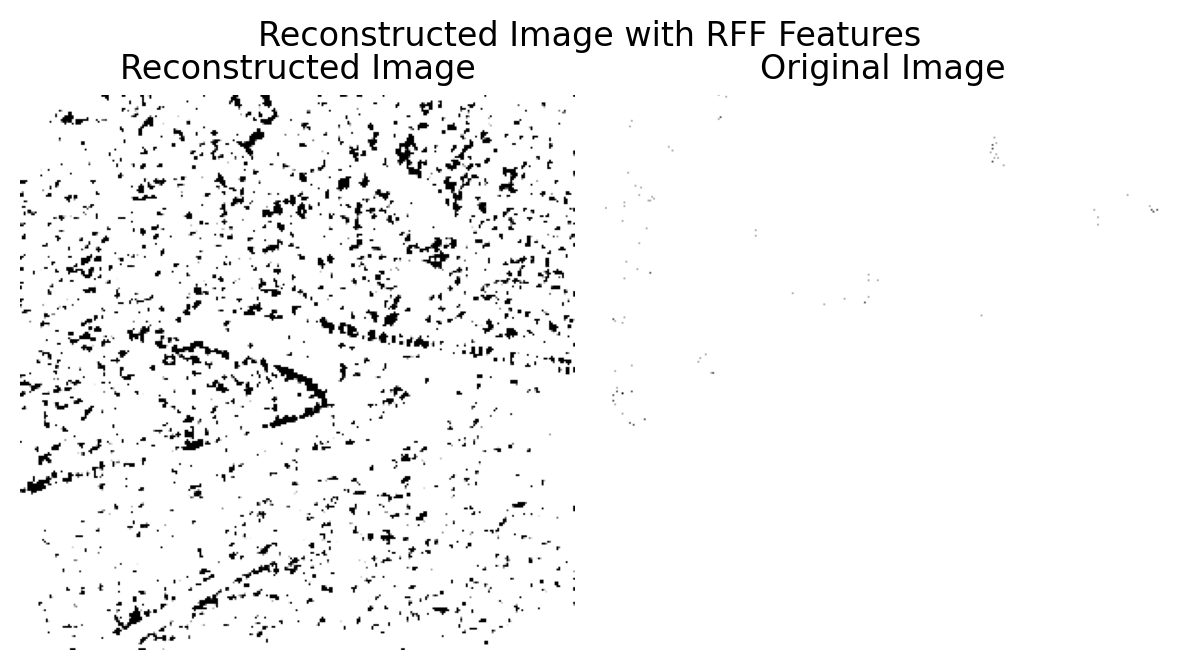

In [23]:
plot_reconstructed_and_original_image(cropped_image, net, X_rff, title="Reconstructed Image with RFF Features")

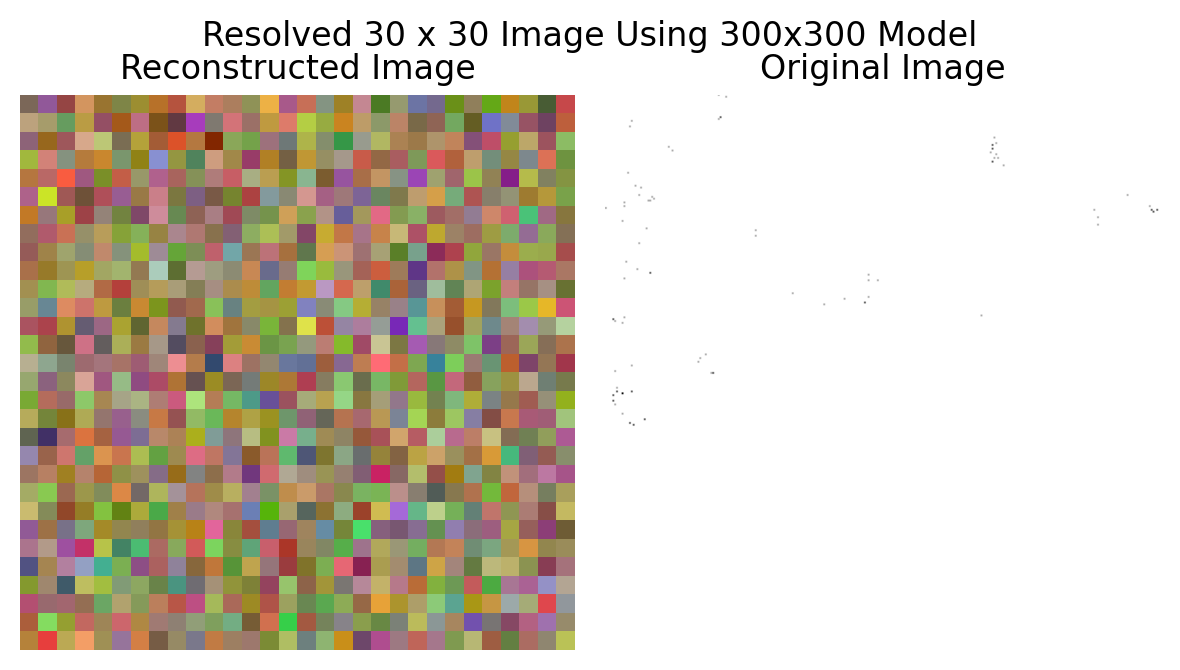

In [24]:
num_rff_features = 5000  # Choose 5000 or any other suitable number of RFF features
X_rff_400 = create_rff_features(road_X_400_scaled, num_rff_features, 0.005, device)  # Use the batch processing RFF function

# Step 3: Reinitialize the model with the new input size (matching the number of RFF features)
net = LinearModel(num_rff_features, 3)  # Adjust input size to match the RFF features generated (5000 in this case)
net.to(device)

# Step 4: Pass the RFF features through the model to reconstruct the 400x400 image
import matplotlib.gridspec as gridspec
def plot_reconstructed_and_original_image(original_img, reconstructed_img, title=""):
    """
    original_img: torch.Tensor of shape (num_channels, height, width)
    reconstructed_img: torch.Tensor of shape (num_channels, height, width)
    """
    num_channels, height, width = original_img.shape

    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(reconstructed_img.cpu().permute(1, 2, 0))
    ax0.set_title("Reconstructed Image")

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")

    fig.suptitle(title, y=0.9)
    plt.tight_layout()
    plt.show()

# Step 4: Pass the RFF features through the model to reconstruct the 400x400 image
net.eval()
with torch.no_grad():
    outputs_400 = net(X_rff_400)
    outputs_400 = outputs_400.reshape(30, 30, 3).permute(2, 0, 1)

# Normalize outputs_400 to the range [0, 1]
outputs_400 = (outputs_400 - outputs_400.min()) / (outputs_400.max() - outputs_400.min())
# Convert to [0, 255] for visualization
outputs_400 = (outputs_400 * 255).clamp(0, 255).byte()

# Plot the reconstructed and original images
plot_reconstructed_and_original_image(cropped_image, outputs_400, title="Resolved 30 x 30 Image Using 300x300 Model")

In [25]:
print(np.shape(outputs_400.cpu()))
print(np.shape(masked_img.cpu()))

torch.Size([3, 30, 30])
torch.Size([3, 30, 30])


In [26]:
import cv2
import numpy as np

outputs_400_np = outputs_400.cpu().numpy()

# Transpose the tensor to (height, width, channels)
outputs_400_np = np.transpose(outputs_400_np, (1, 2, 0))

# Convert the RGB image to grayscale
grayscale_outputs400 = cv2.cvtColor(outputs_400_np, cv2.COLOR_RGB2GRAY)
print(grayscale_outputs400.shape)


(30, 30)


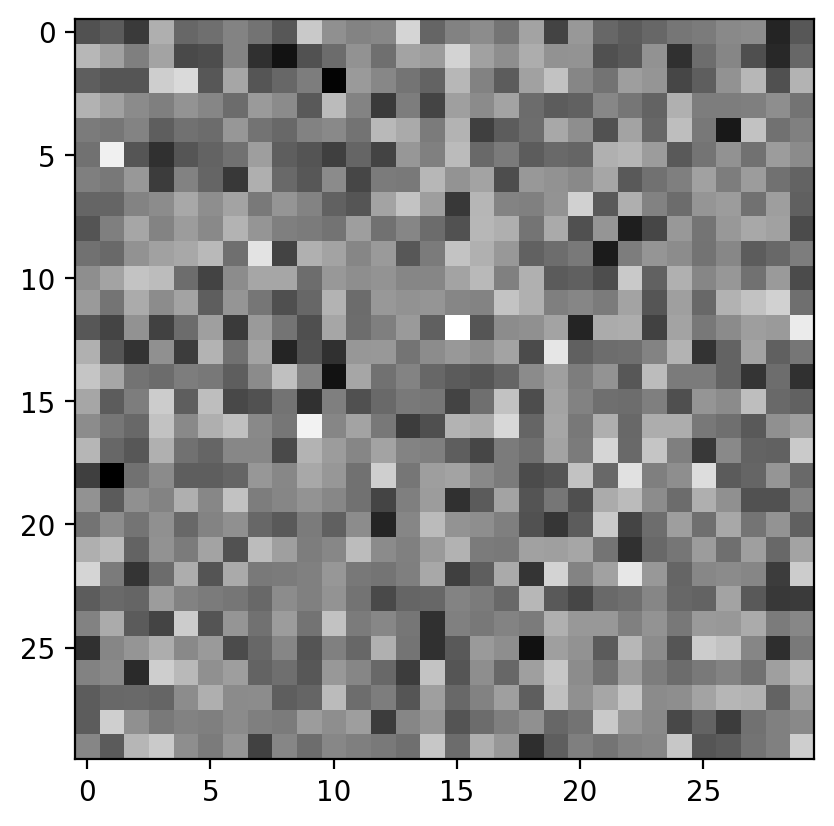

In [27]:
plt.imshow(grayscale_outputs400, cmap = "gray")

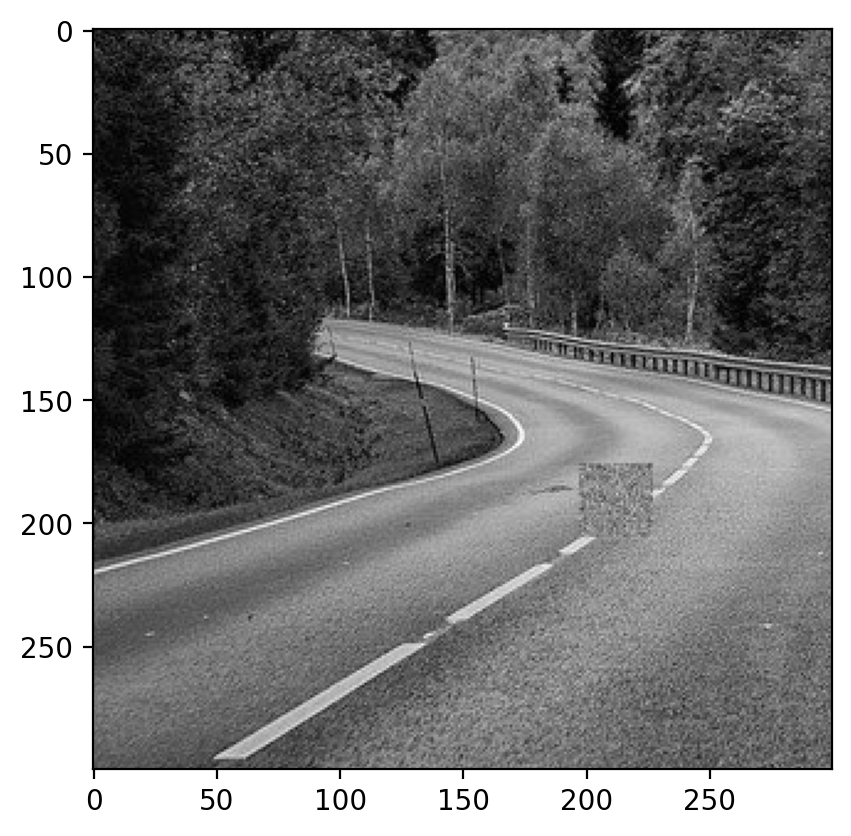

In [34]:
a = 176
b =197
reconstructed_img = mask_900_img
reconstructed_img[a:a+30, b:b+30] = torch.from_numpy(grayscale_outputs400)
plt.imshow(reconstructed_img, cmap = "gray")